In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# Using saas.csv or log data from API usage or store_item_sales

In [2]:
# Importing saas.csv to a Data Frame
df = pd.read_csv('saas.csv')

In [3]:
# Checking Values to make sure import worked out correctly
df.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [4]:
# Taking a look at the columns and Data Types and Non-Null Count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


# Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

## Converting Month_Invoiced to 'datetime64' Data Type

In [5]:
# Converting sale_date type object to datetime64
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

## Need to set the axis as Month_Invoiced

In [6]:
# Making the index equal to the Month_Invoiced
df = df.set_index('Month_Invoiced').sort_index()

In [7]:
# Checking date is sorted correctly
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [8]:
# Checking to see what the last day in my Data Frame is
df.tail(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2017-12-31,1029397,5790455,3.0,15.0
2017-12-31,1029398,5790456,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


## Resampling

In [9]:
df = df.resample('W').sum()

In [10]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-02-02,20199990000,100199990000,7170.0,35850.0
2014-02-09,0,0,0.0,0.0
2014-02-16,0,0,0.0,0.0
2014-02-23,0,0,0.0,0.0
2014-03-02,20000052061,99592010100,7438.0,37190.0


### Dropping Rows Where Amount == 0

In [11]:
df = df[df.Amount != 0]

<AxesSubplot:>

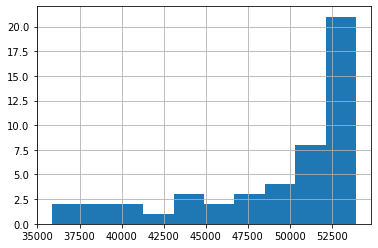

In [12]:
# Checking the Amount distribution
df.Amount.hist()

#### Split 

In [13]:
# Thinking about how i want to split and wanted to know how many rows I had
df_size = len(df)
df_size

48

In [14]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(df_size * .50)
train_size

24

In [15]:
# compute num of rows that are 30% of total rows and assign to variable validate_size

validate_size = int(df_size * .3)
validate_size

14

In [16]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(df_size - train_size - validate_size)
test_size

10

In [17]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

38

## Qauilty Check

In [18]:
# Making sure the numbers add up to the full Data Frame
len(df) == train_size + validate_size + test_size

True

### Train Split 

In [19]:
# train is equal to start of index to train_size which is (df_size * .50) 
train = df[: train_size]
train.shape

(24, 4)

### Validate Split 

In [20]:
# validate is equal to train_size to end of validate_end_index which is (train_size + validate_size)
validate = df[train_size: validate_end_index]
validate.shape

(14, 4)

### Test Split 

In [21]:
# test is equal to validate_end_index to the end of the index
test = df[validate_end_index : ]
test.shape

(10, 4)

# Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

### Reusing Functions

In [22]:
def plot_samples(target_var):
    '''
    this function wil plot the train, validate and test values for a single varibable across all dates
    '''
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

In [23]:
def evaluate(target_var):
    '''
    Creating a function to grab rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [24]:
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(f'--RMSE: {target_var}')
    plt.show()

In [25]:
def append_eval_df(model_type, target_var):
    '''
    this function is goign to take in the model type as a string, the target variable as a string,
    and run the evalute() function to compute the rsme,
    and append to the data frame a row with the model_type, target_var and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [26]:
# Im not using this one, I have just been creating my own yhat everytime.
def make_predictions(target_var):
    yhat_df = pd.DataFrame({'Amount': [target_var]}, index = validate.index)
    return yhat_df

In [27]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

# Simple Average

In [28]:
# Setting out Target as Amount
target_var = "Amount"

In [29]:
# taking the average of amount from TRAIN
amount_mean = round(train.Amount.mean(), 2)
amount_mean

45568.54

In [30]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'Amount': [amount_mean]}, index = validate.index)

In [31]:
yhat_df.head(2)

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-03-06,45568.54


--RMSE: Amount


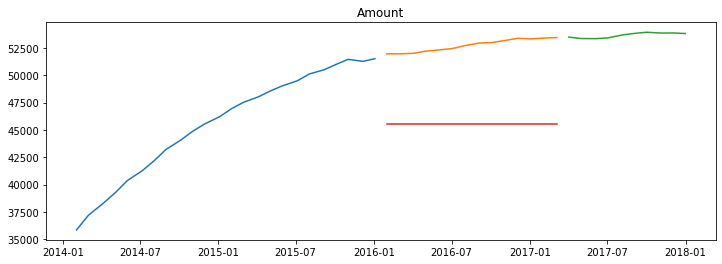

In [32]:
plot_and_eval(target_var)

In [33]:
eval_df = append_eval_df(model_type = 'amount_mean', target_var = target_var)

In [34]:
eval_df

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0


## Moving Average

### 4 Week Rolling

In [35]:
period = 4 # In Weeks
amount_4week_rolling = round(train['Amount'].rolling(period).mean().iloc[-1])
amount_4week_rolling

51299

In [36]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'Amount': [amount_4week_rolling]}, index = validate.index)

In [37]:
yhat_df.head(2)

,Amount
Month_Invoiced,
2016-01-31,51299
2016-03-06,51299


--RMSE: Amount


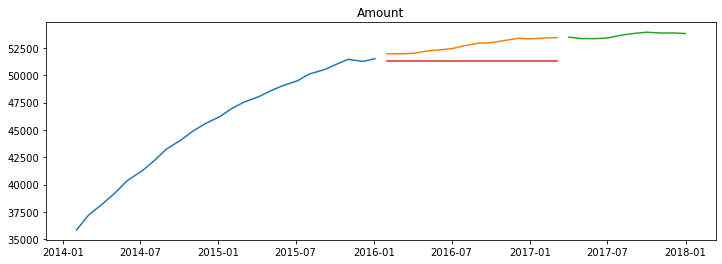

In [38]:
plot_and_eval(target_var)

In [39]:
eval_df = append_eval_df(model_type = '4 Week Rolling', target_var = target_var)

In [40]:
eval_df

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0


### 8 Week Rolling

In [41]:
period = 8 # In Weeks
amount_8week_rolling = round(train['Amount'].rolling(period).mean().iloc[-1])
amount_8week_rolling

50538

In [42]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'Amount': [amount_8week_rolling]}, index = validate.index)

--RMSE: Amount


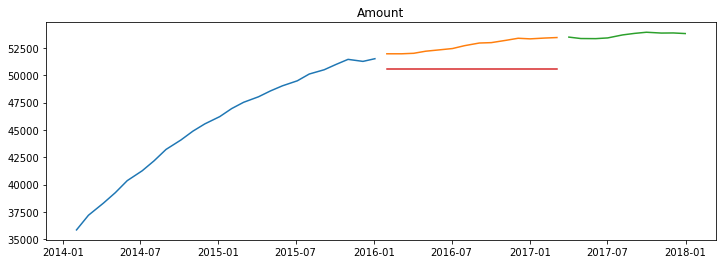

In [43]:
plot_and_eval(target_var)

In [44]:
eval_df = append_eval_df(model_type = '8 Week Rolling', target_var = target_var)
eval_df

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0


### Holt's Linear Trend Model

In [45]:
train_holts = train.copy()
validate_holts = validate.copy()

In [46]:
train_holts = train_holts.Amount.resample('W').sum()
validate_holts = validate_holts.Amount.resample('W').sum()

### Level = .5 / Slope = .5

In [47]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = .5, smoothing_slope = .5, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)


--RMSE: Amount


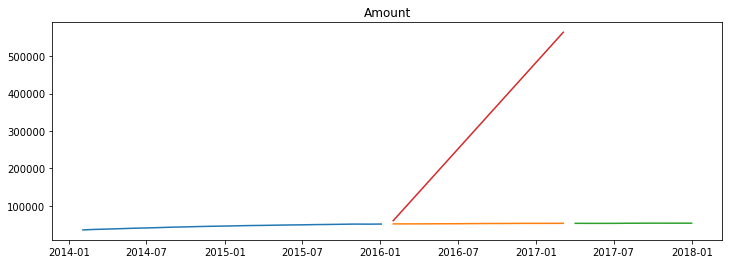

In [48]:
eval_df = append_eval_df(model_type = 'Holts Level=.5 / Slope=.5', target_var = target_var)
plot_and_eval(target_var = target_var)

In [49]:
eval_df

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0


### Level = 1 / Slope = 1

--RMSE: Amount


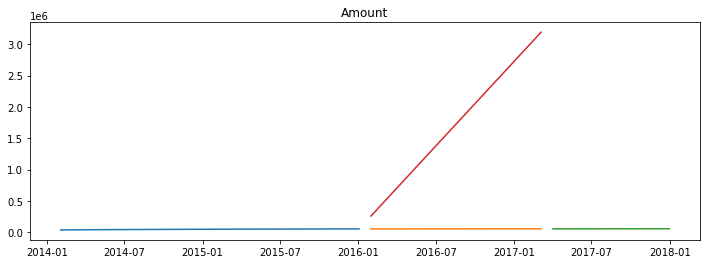

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0
4,Holts Level=1 / Slope=1,Amount,1909761.0


In [50]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = 1, smoothing_slope = 1, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)

eval_df = append_eval_df(model_type = 'Holts Level=1 / Slope=1', target_var = target_var)
plot_and_eval(target_var = target_var)
eval_df

### Level = .1 / Slope = .1

--RMSE: Amount


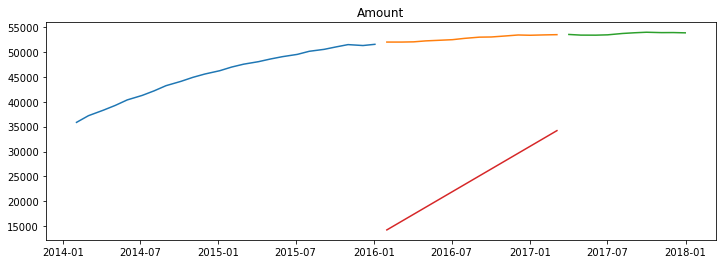

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0
4,Holts Level=1 / Slope=1,Amount,1909761.0
5,Holts Level=.1 / Slope=.1,Amount,28989.0


In [51]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)

eval_df = append_eval_df(model_type = 'Holts Level=.1 / Slope=.1', target_var = target_var)
plot_and_eval(target_var = target_var)
eval_df

### Level = .1 / Slope = .5

--RMSE: Amount


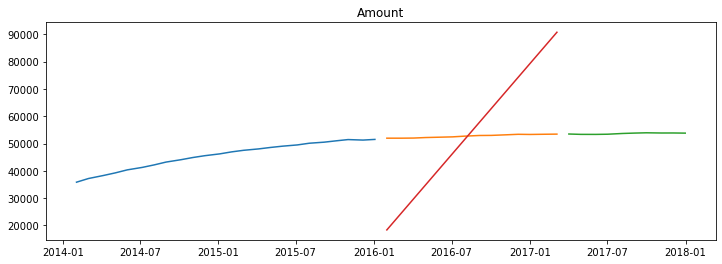

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0
4,Holts Level=1 / Slope=1,Amount,1909761.0
5,Holts Level=.1 / Slope=.1,Amount,28989.0
6,Holts Level=.1 / Slope=.5,Amount,21939.0


In [52]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = .1, smoothing_slope = .5, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)

eval_df = append_eval_df(model_type = 'Holts Level=.1 / Slope=.5', target_var = target_var)
plot_and_eval(target_var = target_var)
eval_df

### Level = .1 / Slope = .3

--RMSE: Amount


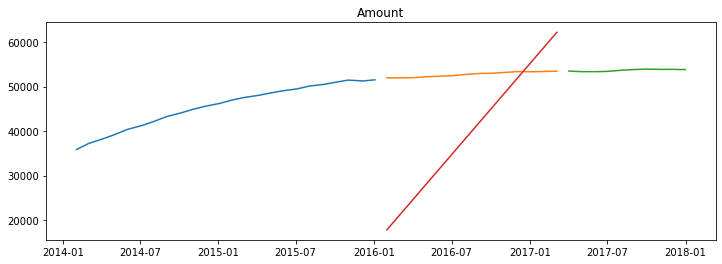

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0
4,Holts Level=1 / Slope=1,Amount,1909761.0
5,Holts Level=.1 / Slope=.1,Amount,28989.0
6,Holts Level=.1 / Slope=.5,Amount,21939.0
7,Holts Level=.1 / Slope=.3,Amount,18266.0


In [53]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = .1, smoothing_slope = .3, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)

eval_df = append_eval_df(model_type = 'Holts Level=.1 / Slope=.3', target_var = target_var)
plot_and_eval(target_var = target_var)
eval_df

### Level = .4 / Slope = .01

--RMSE: Amount


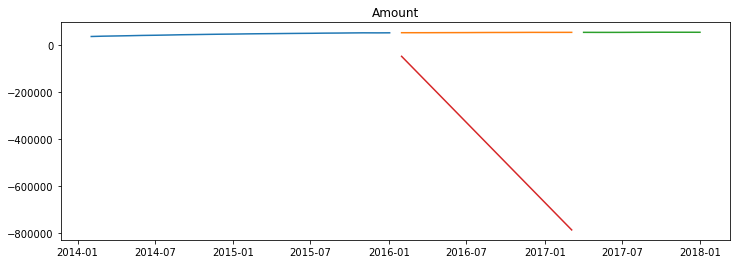

,model_type,target_var,rmse
0,amount_mean,Amount,7181.0
1,4 Week Rolling,Amount,1533.0
2,8 Week Rolling,Amount,2259.0
3,Holts Level=.5 / Slope=.5,Amount,303537.0
4,Holts Level=1 / Slope=1,Amount,1909761.0
5,Holts Level=.1 / Slope=.1,Amount,28989.0
6,Holts Level=.1 / Slope=.5,Amount,21939.0
7,Holts Level=.1 / Slope=.3,Amount,18266.0
8,Holts Level=.4 / Slope=.01,Amount,524968.0


In [54]:
# Making the model
model = Holt(train_holts, exponential = False)

# Fitting the model
model = model.fit(smoothing_level = .4, smoothing_slope = .01, optimized = False)

# Making predictions 
yhat = model.predict(start = validate_holts.index[0], end = validate_holts.index[-1])

yhat_df['Amount'] = round(yhat, 0)

eval_df = append_eval_df(model_type = 'Holts Level=.4 / Slope=.01', target_var = target_var)
plot_and_eval(target_var = target_var)
eval_df

# Resplit the Data

In [208]:
df = pd.read_csv('saas.csv')
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df = df.set_index('Month_Invoiced').sort_index()
df = df[df.index != '2016-02-29']

In [214]:
train = df['2015':'2016']
validate = df['2016']
test = df['2017']

In [215]:
train = train.Amount.resample("W").sum()
validate = validate.Amount.resample("W").sum()
test = test.Amount.resample("W").sum()

In [216]:
# make predictions
train = train.fillna(0)
validate = validate.fillna(0)
test = test.fillna(0)

In [217]:
len(train), len(validate), len(test)

(101, 49, 48)

In [218]:
train.head(1)

Month_Invoiced
2015-02-01    46945.0
Freq: W-SUN, Name: Amount, dtype: float64

In [219]:
train.tail(1)

Month_Invoiced
2017-01-01    53320.0
Freq: W-SUN, Name: Amount, dtype: float64

In [204]:
# make predictions
yhat_df = round(train['2015'] + train.diff(3).mean(),2)

AttributeError: 'Series' object has no attribute 'set_index'

### Based on previous year/month/etc., this is up to you.